Loading tokenized data from tokenized_logs.pt ...
Data shapes: input_ids=torch.Size([7000, 128]), attention_mask=torch.Size([7000, 128]), labels=torch.Size([7000])
Benign samples available: 5000
Train benign samples: 4500, Val benign samples: 500
Starting training...
Epoch [1/10] Train Loss: 0.039778  Val Loss: 0.000637  Val Acc: 0.9680  Threshold: 0.000874
Epoch [2/10] Train Loss: 0.002165  Val Loss: 0.000491  Val Acc: 0.9700  Threshold: 0.000711
Epoch [3/10] Train Loss: 0.001659  Val Loss: 0.000516  Val Acc: 0.9680  Threshold: 0.000675
Epoch [4/10] Train Loss: 0.001419  Val Loss: 0.000521  Val Acc: 0.9740  Threshold: 0.000658
Epoch [5/10] Train Loss: 0.001381  Val Loss: 0.000407  Val Acc: 0.9760  Threshold: 0.000525
Epoch [6/10] Train Loss: 0.001256  Val Loss: 0.000388  Val Acc: 0.9720  Threshold: 0.000483
Epoch [7/10] Train Loss: 0.001211  Val Loss: 0.000516  Val Acc: 0.9840  Threshold: 0.000643
Epoch [8/10] Train Loss: 0.001227  Val Loss: 0.000296  Val Acc: 0.9600  Threshold: 0.000

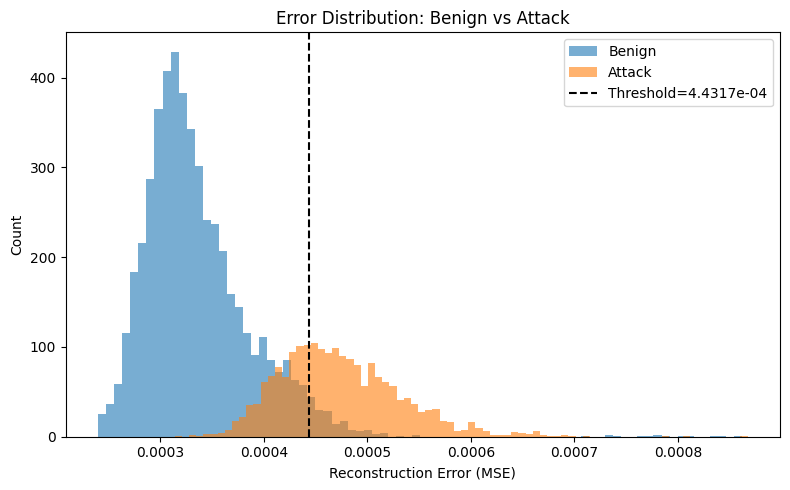

Error histogram saved to error_histogram.png


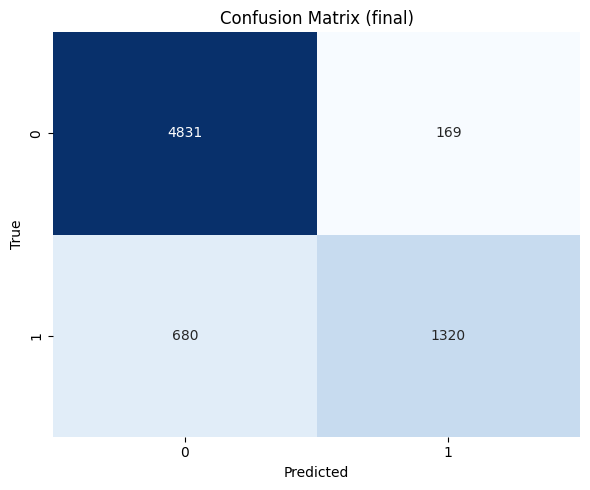

Confusion matrix saved to confusion_matrix.png

Confusion matrix (tn, fp, fn, tp): 4831, 169, 680, 1320


In [1]:
import os
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from transformers import AutoModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
)
import seaborn as sns

# ------------------------------
# CONFIG
# ------------------------------
TOKENIZED_FILE = "tokenized_logs.pt"   # tokenized tensors
MODEL_SAVE_PATH = "distilroberta_autoencoder.pt"
ERRORS_CSV = "reconstruction_errors.csv"
LOSS_PLOT = "train_loss_curve.png"
ERROR_HIST_PLOT = "error_histogram.png"
CONF_MATRIX_PLOT = "confusion_matrix.png"
ACC_PLOT = "val_accuracy_curve.png"

BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3
LATENT_DIM = 256
VAL_SPLIT = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------
# DATASET
# ------------------------------


class LogDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }


# ------------------------------
# MODEL: DistilRoBERTa Autoencoder on CLS embedding
# ------------------------------


class DistilRobertaAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        # DistilRoBERTa encoder
        self.encoder = AutoModel.from_pretrained("distilroberta-base")
        hidden_size = self.encoder.config.hidden_size  # typically 768

        # Freeze encoder to keep training light
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Bottleneck MLP: hidden_size -> latent_dim -> hidden_size
        self.project_down = nn.Linear(hidden_size, latent_dim)
        self.activation = nn.ReLU()
        self.project_up = nn.Linear(latent_dim, hidden_size)

    def forward(self, input_ids, attention_mask):
        # Encode with frozen DistilRoBERTa
        # Note: encoder outputs tensors on same device as input tensors
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
            cls_emb = outputs.last_hidden_state[:, 0, :]  # [batch, hidden]
        # Autoencoder head (trainable)
        z = self.project_down(cls_emb)
        z = self.activation(z)
        recon = self.project_up(z)  # [batch, hidden]
        return cls_emb, recon


# ------------------------------
# LOAD TOKENIZED DATA
# ------------------------------
print(f"Loading tokenized data from {TOKENIZED_FILE} ...")
data = torch.load(TOKENIZED_FILE, weights_only=False)

input_ids = data["input_ids"]
attention_mask = data["attention_mask"]
labels = data["labels"].long()  # ensure long tensor for indices

print(f"Data shapes: input_ids={input_ids.shape}, attention_mask={attention_mask.shape}, labels={labels.shape}")

# Build datasets
dataset = LogDataset(input_ids, attention_mask, labels)

# ------------------------------
# TRAIN ONLY ON BENIGN LOGS (label == 0)
# ------------------------------
labels_np = labels.cpu().numpy()
benign_indices = np.where(labels_np == 0)[0].tolist()
print(f"Benign samples available: {len(benign_indices)}")

# Create a Subset dataset of benign samples
benign_subset = Subset(dataset, benign_indices)

# Train/Val split on benign only
val_size = int(len(benign_subset) * VAL_SPLIT)
train_size = len(benign_subset) - val_size
if val_size <= 0:
    val_size = max(1, int(len(benign_subset) * 0.1))
    train_size = len(benign_subset) - val_size

train_subset, val_subset = random_split(
    benign_subset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

# Full loader for evaluation (all samples)
full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train benign samples: {len(train_subset)}, Val benign samples: {len(val_subset)}")

# ------------------------------
# INIT MODEL, LOSS, OPT
# ------------------------------
model = DistilRobertaAutoencoder(latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

# ------------------------------
# HELPERS: compute per-sample MSE errors for a loader
# ------------------------------
def compute_reconstruction_errors(model, loader, device=DEVICE):
    model.eval()
    errors = []
    labels_list = []
    with torch.no_grad():
        for batch in loader:
            input_ids_b = batch["input_ids"].to(device)
            attention_mask_b = batch["attention_mask"].to(device)
            labels_b = batch["labels"].cpu().numpy()
            original, recon = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
            # per-sample MSE across hidden dim
            mse_per_sample = ((original - recon) ** 2).mean(dim=1).cpu().numpy()
            errors.extend(mse_per_sample.tolist())
            labels_list.extend(labels_b.tolist())
    return np.array(errors), np.array(labels_list)


# ------------------------------
# TRAINING LOOP (with epoch-wise metrics)
# ------------------------------
train_losses = []
val_losses = []
val_accuracies = []
thresholds = []

print("Starting training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    count = 0
    for batch in train_loader:
        input_ids_b = batch["input_ids"].to(DEVICE)
        attention_mask_b = batch["attention_mask"].to(DEVICE)

        original, recon = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
        loss = criterion(recon, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * input_ids_b.size(0)
        count += input_ids_b.size(0)

    train_loss = running_loss / max(count, 1)
    train_losses.append(train_loss)

    # Evaluate validation loss
    val_loss = 0.0
    val_count = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids_b = batch["input_ids"].to(DEVICE)
            attention_mask_b = batch["attention_mask"].to(DEVICE)
            original, recon = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
            loss_b = criterion(recon, original)
            val_loss += loss_b.item() * input_ids_b.size(0)
            val_count += input_ids_b.size(0)
    val_loss = val_loss / max(val_count, 1)
    val_losses.append(val_loss)

    # Compute train benign errors (use train_loader) to set threshold
    train_errors, train_labels = compute_reconstruction_errors(model, train_loader, device=DEVICE)
    # train_labels should be all zeros
    mean_b = train_errors.mean()
    std_b = train_errors.std()
    threshold = mean_b + 2 * std_b
    thresholds.append(threshold)

    # Compute val errors and accuracy using threshold
    val_errors, val_labels = compute_reconstruction_errors(model, val_loader, device=DEVICE)
    val_preds = (val_errors > threshold).astype(int)
    # val_labels are zeros (benign), so accuracy will be proportion predicted benign (i.e., preds==0)
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch}/{EPOCHS}] Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}  Val Acc: {val_acc:.4f}  Threshold: {threshold:.6f}")

print("Training finished!")

# Save model weights (state_dict)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# ------------------------------
# FINAL EVALUATION ON ALL SAMPLES
# ------------------------------
all_errors, all_labels = compute_reconstruction_errors(model, full_loader, device=DEVICE)
# Use final epoch threshold (last computed)
final_threshold = thresholds[-1]
preds = (all_errors > final_threshold).astype(int)

acc = accuracy_score(all_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, preds, average="binary", pos_label=1)
try:
    auc = roc_auc_score(all_labels, all_errors)
except Exception:
    auc = float("nan")

print("\nFinal Anomaly Detection Metrics (using threshold from last epoch):")
print(f"Threshold: {final_threshold:.6f}")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

# ------------------------------
# SAVE ERRORS + LABELS + PREDICTIONS TO CSV
# ------------------------------
with open(ERRORS_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["index", "reconstruction_error", "label", "pred"])
    for i, (err, lab, pr) in enumerate(zip(all_errors.tolist(), all_labels.tolist(), preds.tolist())):
        writer.writerow([i, err, lab, pr])

print(f"Reconstruction errors saved to {ERRORS_CSV}")

# ------------------------------
# PLOTTING
# ------------------------------

# Loss curve (train & val)
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Train/Val Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(LOSS_PLOT)
plt.close()
print(f"Loss curve saved to {LOSS_PLOT}")

# Accuracy curve (val accuracy per epoch)
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), val_accuracies, label="Val Accuracy (benign-only validation)", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (using threshold from train benign errors)")
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.tight_layout()
plt.savefig(ACC_PLOT)
plt.close()
print(f"Accuracy curve saved to {ACC_PLOT}")

# Error distribution histogram (benign vs attack)
plt.figure(figsize=(8, 5))
benign_mask_all = all_labels == 0
attack_mask_all = all_labels == 1
plt.hist(all_errors[benign_mask_all], bins=80, alpha=0.6, label="Benign")
plt.hist(all_errors[attack_mask_all], bins=80, alpha=0.6, label="Attack")
plt.axvline(final_threshold, color="k", linestyle="--", label=f"Threshold={final_threshold:.4e}")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Count")
plt.title("Error Distribution: Benign vs Attack")
plt.legend()
plt.tight_layout()
plt.savefig(ERROR_HIST_PLOT)
plt.show()
plt.close()

print(f"Error histogram saved to {ERROR_HIST_PLOT}")

# Confusion matrix (final)
cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (final)")
plt.tight_layout()
plt.savefig(CONF_MATRIX_PLOT)
plt.show()
plt.close()
print(f"Confusion matrix saved to {CONF_MATRIX_PLOT}")

# ------------------------------
# OPTIONAL: Print small summary of confusion matrix numbers
# ------------------------------
tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
print(f"\nConfusion matrix (tn, fp, fn, tp): {tn}, {fp}, {fn}, {tp}")

# ------------------------------
# DONE
# ------------------------------



Loading tokenized data from tokenized_logs.pt ...
Data shapes: input_ids=torch.Size([7000, 128]), attention_mask=torch.Size([7000, 128]), labels=torch.Size([7000])
Benign samples available: 5000
Train benign samples: 4500, Val benign samples: 500
[unfreeze_last_n_layers] Unfroze last 2/6 layers (and embeddings/layernorms where found).
Trainable parameters: 53,582,848 / 82,512,640
Starting fine-tuning training...


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:266: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if DEVICE.startswith("cuda") else None
C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10] Train Loss: 0.076438  Val Loss: 0.000529  Val Acc: 0.9780  Threshold: 0.000653  Time: 37.0s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [2/10] Train Loss: 0.002155  Val Loss: 0.000376  Val Acc: 0.9600  Threshold: 0.000463  Time: 37.0s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [3/10] Train Loss: 0.001362  Val Loss: 0.000253  Val Acc: 0.9800  Threshold: 0.000307  Time: 37.4s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [4/10] Train Loss: 0.000939  Val Loss: 0.000166  Val Acc: 0.9700  Threshold: 0.000212  Time: 37.5s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [5/10] Train Loss: 0.000794  Val Loss: 0.000150  Val Acc: 0.9640  Threshold: 0.000186  Time: 37.6s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [6/10] Train Loss: 0.000613  Val Loss: 0.000112  Val Acc: 0.9520  Threshold: 0.000154  Time: 37.5s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [7/10] Train Loss: 0.000547  Val Loss: 0.000082  Val Acc: 0.9780  Threshold: 0.000112  Time: 37.4s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [8/10] Train Loss: 0.000498  Val Loss: 0.000062  Val Acc: 0.9660  Threshold: 0.000094  Time: 37.5s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [9/10] Train Loss: 0.000427  Val Loss: 0.000053  Val Acc: 0.9780  Threshold: 0.000080  Time: 37.3s
Saved best model to distilroberta_autoencoder_best.pt


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [10/10] Train Loss: 0.000426  Val Loss: 0.000039  Val Acc: 0.9780  Threshold: 0.000064  Time: 37.2s
Saved best model to distilroberta_autoencoder_best.pt
Fine-tuning finished!


C:\Users\chall\AppData\Local\Temp\ipykernel_17248\185408906.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVIC

Loaded best model from checkpoint (epoch 10). Using threshold=0.000064

Final Anomaly Detection Metrics (using threshold from checkpoint):
Threshold: 0.000064
Accuracy : 0.8347
Precision: 0.9236
Recall   : 0.4595
F1-score : 0.6137
ROC AUC  : 0.9492
Reconstruction errors saved to reconstruction_errors.csv


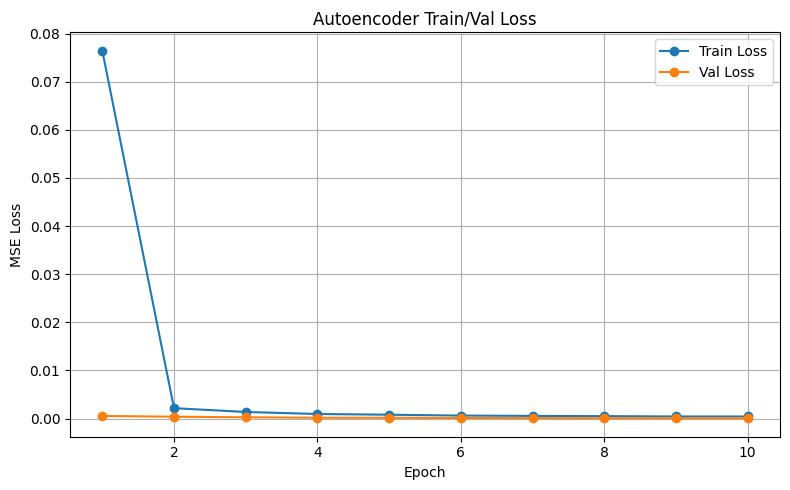

Loss curve saved to train_loss_curve.png


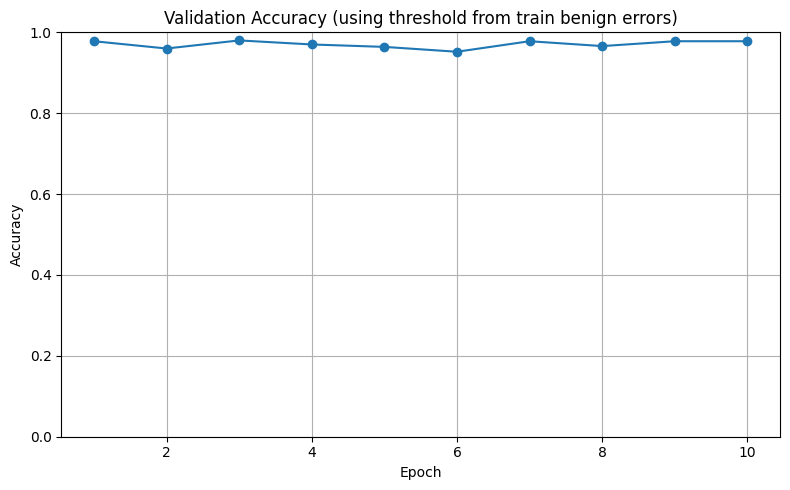

Accuracy curve saved to val_accuracy_curve.png


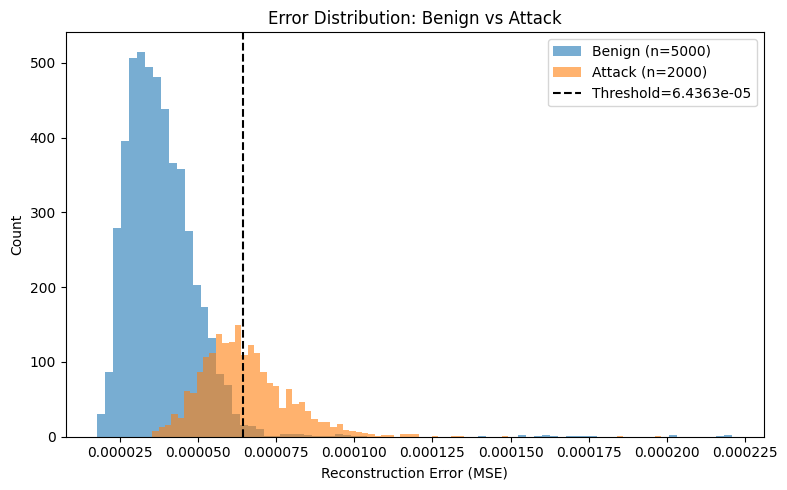

Error histogram saved to error_histogram.png


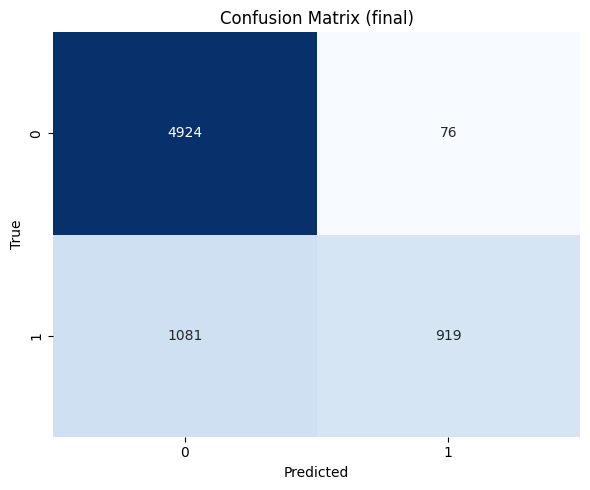

Confusion matrix saved to confusion_matrix.png

Confusion matrix (tn, fp, fn, tp): 4924, 76, 1081, 919

Done.


In [3]:
#!/usr/bin/env python3
"""
finetune_roberta_autoencoder.py

Complete script to fine-tune last N layers of DistilRoBERTa encoder and train
an autoencoder head on CLS embeddings for anomaly detection.

Requirements:
- transformers
- torch
- scikit-learn
- matplotlib
- seaborn
- numpy
"""

import os
import csv
import math
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from transformers import AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW      

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
)
import seaborn as sns

# ------------------------------
# CONFIG (edit as needed)
# ------------------------------
TOKENIZED_FILE = "tokenized_logs.pt"   # must contain dict with keys: input_ids, attention_mask, labels
MODEL_SAVE_PATH = "distilroberta_autoencoder_best.pt"
ERRORS_CSV = "reconstruction_errors.csv"
LOSS_PLOT = "train_loss_curve.png"
ERROR_HIST_PLOT = "error_histogram.png"
CONF_MATRIX_PLOT = "confusion_matrix.png"
ACC_PLOT = "val_accuracy_curve.png"

BATCH_SIZE = 32
EPOCHS = 10
LR_HEAD = 1e-3      # LR for autoencoder head
LR_ENCODER = 1e-5   # LR for encoder (small)
LATENT_DIM = 256
VAL_SPLIT = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

UNFREEZE_LAST_N = 2  # <--- you chose option B: unfreeze last 2 layers

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------
# DATASET
# ------------------------------
class LogDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

# ------------------------------
# MODEL: DistilRoBERTa Autoencoder on CLS embedding
# ------------------------------
class DistilRobertaAutoencoder(nn.Module):
    def __init__(self, latent_dim=256, pretrained_model_name="distilroberta-base"):
        super().__init__()
        # DistilRoBERTa encoder
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        hidden_size = self.encoder.config.hidden_size  # typically 768

        # Bottleneck MLP: hidden_size -> latent_dim -> hidden_size
        self.project_down = nn.Linear(hidden_size, latent_dim)
        self.activation = nn.ReLU()
        self.project_up = nn.Linear(latent_dim, hidden_size)

    def forward(self, input_ids, attention_mask):
        # Encode (allow gradients for finetuning selected layers)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # last_hidden_state shape [batch, seq_len, hidden]
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [batch, hidden]
        # Autoencoder head (trainable)
        z = self.project_down(cls_emb)
        z = self.activation(z)
        recon = self.project_up(z)  # [batch, hidden]
        return cls_emb, recon

# ------------------------------
# utilities
# ------------------------------
def unfreeze_last_n_layers(model_encoder, n=2):
    """
    Unfreeze last `n` transformer layers of a HF encoder.
    The function tries multiple attribute paths to be robust.
    """
    # Freeze all first
    for p in model_encoder.parameters():
        p.requires_grad = False

    layers = None
    # Try common attribute paths
    possible_paths = [
        ("transformer", "layer"),
        ("distilbert", "transformer", "layer"),
        ("encoder", "layer"),
        ("roberta", "encoder", "layer"),
    ]
    for path in possible_paths:
        try:
            obj = model_encoder
            for attr in path:
                obj = getattr(obj, attr)
            layers = obj
            break
        except Exception:
            layers = None

    if layers is None:
        # fallback: try to find any attribute named "layer" recursively
        for name, module in model_encoder.named_modules():
            if name.endswith("layer") and hasattr(module, "__len__"):
                layers = module
                break

    if layers is None:
        # fallback: unfreeze entire encoder (not ideal but safe)
        for p in model_encoder.parameters():
            p.requires_grad = True
        print("[unfreeze_last_n_layers] Warning: couldn't find layer list; unfroze whole encoder.")
        return

    total = len(layers)
    n = max(0, min(n, total))
    # unfreeze last n
    for layer in layers[-n:]:
        for p in layer.parameters():
            p.requires_grad = True
    # also unfreeze embeddings & layernorms which often help stability
    for name, p in model_encoder.named_parameters():
        if "embeddings" in name or "layernorm" in name.lower() or "ln" in name.lower():
            p.requires_grad = True

    print(f"[unfreeze_last_n_layers] Unfroze last {n}/{total} layers (and embeddings/layernorms where found).")

def compute_reconstruction_errors(model, loader, device=DEVICE):
    model.eval()
    errors = []
    labels_list = []
    with torch.no_grad():
        for batch in loader:
            input_ids_b = batch["input_ids"].to(device)
            attention_mask_b = batch["attention_mask"].to(device)
            labels_b = batch["labels"].cpu().numpy()
            original, recon = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
            mse_per_sample = ((original - recon) ** 2).mean(dim=1).cpu().numpy()
            errors.extend(mse_per_sample.tolist())
            labels_list.extend(labels_b.tolist())
    return np.array(errors), np.array(labels_list)

# ------------------------------
# LOAD TOKENIZED DATA
# ------------------------------
print(f"Loading tokenized data from {TOKENIZED_FILE} ...")
data = torch.load(TOKENIZED_FILE, weights_only=False)  # adjust map_location if needed

input_ids = data["input_ids"]
attention_mask = data["attention_mask"]
labels = data["labels"].long()

print(f"Data shapes: input_ids={input_ids.shape}, attention_mask={attention_mask.shape}, labels={labels.shape}")

# Build dataset and benign subset
dataset = LogDataset(input_ids, attention_mask, labels)
labels_np = labels.cpu().numpy()
benign_indices = np.where(labels_np == 0)[0].tolist()
print(f"Benign samples available: {len(benign_indices)}")

benign_subset = Subset(dataset, benign_indices)

# Train/Val split on benign only
val_size = int(len(benign_subset) * VAL_SPLIT)
train_size = len(benign_subset) - val_size
if val_size <= 0:
    val_size = max(1, int(len(benign_subset) * 0.1))
    train_size = len(benign_subset) - val_size

train_subset, val_subset = random_split(
    benign_subset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train benign samples: {len(train_subset)}, Val benign samples: {len(val_subset)}")

# ------------------------------
# INIT MODEL, LOSS, OPTIMIZER, SCHEDULER FOR FINETUNING
# ------------------------------
model = DistilRobertaAutoencoder(latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()

# Unfreeze last N encoder layers (your choice: UNFREEZE_LAST_N)
unfreeze_last_n_layers(model.encoder, n=UNFREEZE_LAST_N)

# Sanity: count trainable params
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")

# Create parameter groups
encoder_params = []
head_params = []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    # treat encoder params differently if they belong to encoder
    if name.startswith("encoder"):
        encoder_params.append(p)
    else:
        head_params.append(p)

# fallback: if encoder_params empty, treat all as head
if len(encoder_params) == 0:
    encoder_params = head_params
    head_params = []

weight_decay = 1e-2
optim_groups = []
if encoder_params:
    optim_groups.append({"params": encoder_params, "lr": LR_ENCODER, "weight_decay": weight_decay})
if head_params:
    optim_groups.append({"params": head_params, "lr": LR_HEAD, "weight_decay": 0.0})

optimizer = AdamW(optim_groups, lr=LR_HEAD, eps=1e-8)

# scheduler: linear warmup + decay
total_train_steps = math.ceil(len(train_loader) * EPOCHS)
warmup_steps = int(0.05 * total_train_steps) if total_train_steps > 0 else 0
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_train_steps)

# Mixed precision scaler
from torch import amp

scaler = amp.GradScaler(device_type="cuda") if DEVICE.startswith("cuda") else None


# ------------------------------
# TRAINING LOOP (with epoch-wise metrics)
# ------------------------------
train_losses = []
val_losses = []
val_accuracies = []
thresholds = []

max_grad_norm = 1.0
best_val_loss = float("inf")
patience = 3
no_improve = 0

print("Starting fine-tuning training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    count = 0
    epoch_start = time.time()

    for batch in train_loader:
        input_ids_b = batch["input_ids"].to(DEVICE)
        attention_mask_b = batch["attention_mask"].to(DEVICE)

        optimizer.zero_grad()

        if scaler is not None:
            with amp.autocast(device_type="cuda"):
                original, recon = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
                loss = criterion(recon, original)
            scaler.scale(loss).backward()
            # unscale for clipping & step
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            original, recon = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
            loss = criterion(recon, original)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * input_ids_b.size(0)
        count += input_ids_b.size(0)

    train_loss = running_loss / max(count, 1)
    train_losses.append(train_loss)

    # Validation loss
    val_loss = 0.0
    val_count = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids_b = batch["input_ids"].to(DEVICE)
            attention_mask_b = batch["attention_mask"].to(DEVICE)
            original, recon = model(input_ids=input_ids_b, attention_mask=attention_mask_b)
            loss_b = criterion(recon, original)
            val_loss += loss_b.item() * input_ids_b.size(0)
            val_count += input_ids_b.size(0)
    val_loss = val_loss / max(val_count, 1)
    val_losses.append(val_loss)

    # Compute train benign errors to set threshold
    train_errors, train_labels = compute_reconstruction_errors(model, train_loader, device=DEVICE)
    mean_b = train_errors.mean()
    std_b = train_errors.std()
    threshold = mean_b + 2 * std_b
    thresholds.append(threshold)

    # Compute val errors and accuracy using threshold
    val_errors, val_labels = compute_reconstruction_errors(model, val_loader, device=DEVICE)
    val_preds = (val_errors > threshold).astype(int)
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch}/{EPOCHS}] Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}  Val Acc: {val_acc:.4f}  Threshold: {threshold:.6f}  Time: {epoch_time:.1f}s")

    # checkpoint by val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
            "threshold": threshold,
            "train_loss": train_loss,
            "val_loss": val_loss,
        }, MODEL_SAVE_PATH)
        print(f"Saved best model to {MODEL_SAVE_PATH}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement in {patience} epochs — early stopping.")
            break

print("Fine-tuning finished!")

# reload best checkpoint (safe)
if os.path.exists(MODEL_SAVE_PATH):
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])
    final_threshold = checkpoint.get("threshold", thresholds[-1] if thresholds else 0.0)
    print(f"Loaded best model from checkpoint (epoch {checkpoint.get('epoch', '?')}). Using threshold={final_threshold:.6f}")
else:
    final_threshold = thresholds[-1] if thresholds else 0.0
    print("No checkpoint found; using last epoch threshold.")

# ------------------------------
# FINAL EVALUATION ON ALL SAMPLES
# ------------------------------
all_errors, all_labels = compute_reconstruction_errors(model, full_loader, device=DEVICE)
preds = (all_errors > final_threshold).astype(int)

acc = accuracy_score(all_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, preds, average="binary", pos_label=1)
try:
    auc = roc_auc_score(all_labels, all_errors)
except Exception:
    auc = float("nan")

print("\nFinal Anomaly Detection Metrics (using threshold from checkpoint):")
print(f"Threshold: {final_threshold:.6f}")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

# ------------------------------
# SAVE ERRORS + LABELS + PREDICTIONS TO CSV
# ------------------------------
with open(ERRORS_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["index", "reconstruction_error", "label", "pred"])
    for i, (err, lab, pr) in enumerate(zip(all_errors.tolist(), all_labels.tolist(), preds.tolist())):
        writer.writerow([i, err, lab, pr])

print(f"Reconstruction errors saved to {ERRORS_CSV}")

# ------------------------------
# PLOTTING
# ------------------------------
# Loss curve (train & val)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Train/Val Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(LOSS_PLOT)
plt.show()
plt.close()
print(f"Loss curve saved to {LOSS_PLOT}")

# Accuracy curve (val accuracy per epoch)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy (benign-only validation)", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (using threshold from train benign errors)")
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.tight_layout()
plt.savefig(ACC_PLOT)
plt.show()
plt.close()
print(f"Accuracy curve saved to {ACC_PLOT}")

# Error distribution histogram (benign vs attack, if attacks exist)
plt.figure(figsize=(8, 5))
benign_mask_all = all_labels == 0
attack_mask_all = all_labels == 1
if benign_mask_all.sum() > 0:
    plt.hist(all_errors[benign_mask_all], bins=80, alpha=0.6, label=f"Benign (n={benign_mask_all.sum()})")
if attack_mask_all.sum() > 0:
    plt.hist(all_errors[attack_mask_all], bins=80, alpha=0.6, label=f"Attack (n={attack_mask_all.sum()})")
plt.axvline(final_threshold, color="k", linestyle="--", label=f"Threshold={final_threshold:.4e}")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Count")
plt.title("Error Distribution: Benign vs Attack")
plt.legend()
plt.tight_layout()
plt.savefig(ERROR_HIST_PLOT)
plt.show()
plt.close()
print(f"Error histogram saved to {ERROR_HIST_PLOT}")

# Confusion matrix (final)
cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (final)")
plt.tight_layout()
plt.savefig(CONF_MATRIX_PLOT)
plt.show()
plt.close()
print(f"Confusion matrix saved to {CONF_MATRIX_PLOT}")

# Small summary of confusion matrix numbers
if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
else:
    tn = fp = fn = tp = 0
print(f"\nConfusion matrix (tn, fp, fn, tp): {tn}, {fp}, {fn}, {tp}")

print("\nDone.")
